In [1]:
! pip install keras_vggface

You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

# Load VGGFace model
vggface_model = VGGFace(model='vgg16') 

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
580075520/580070376 [==============================] - 3s 0us/step


In [8]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import pandas as pd 
import cv2 
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import shutil

import os
print(os.listdir("../input"))




['cv-presonal-2', 'cv-proj-test', 'cv-vidit', 'football-cv', '5-celebrity-faces-dataset', 'facenet-keras']


In [6]:
# load the facenet model
facenet_model = load_model('../input/facenet-keras/facenet_keras.h5')
print('Loaded Model')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded Model


/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [61]:

# Function to create clusters of indexes given the inmput similarity matrix, similarityp[i][j] represents the similarity between i and j
def get_clusters(similarity):
    similarity = similarity / np.max(similarity)
    num_images = similarity.shape[0]
    print(similarity)
    clusters = {}
    image_hash = np.zeros(num_images)
    for i in range(len(image_hash)):
        if image_hash[i] == 0:
            clusters[i] = []
            image_hash[i] = 1
            for j in range(num_images):
                if (i == j or image_hash[j] == 1):
                     continue
                else :
                    threshold = 0.3
                    if(similarity[i][j] > threshold):
                        clusters[i].append(j)
                        image_hash[j] = 1
                        
    return clusters


In [62]:
# Function to detect all the faces in a image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
def detect_faces(img_path):
    img = cv2.imread(img_path)
    #detect all faces
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    face_images = []
    for i, (x, y, w, h) in enumerate(faces):
        # Crop the detected face region
        face_image = img[y:y+h, x:x+w, :]
        face_images.append(face_image)
    print(len(face_images), img_path)    
    if(len(face_images) == 1):
        plt.imshow(face_images[0])
        plt.show()
    else:
        fig, ax = plt.subplots(1, len(face_images))
        for i in range(len(face_images)):
            ax[i].imshow(face_images[i])
        plt.show()
    return face_images


#  Calculates the feature map corresponding to image using VGG16
def get_embeddings(face):
    face = face.astype('float32')
    face = cv2.resize(face, (224, 224))
    face = preprocess_input(face, version=1)
    sample = np.expand_dims(face, axis=0)
    return vggface_model.predict(sample)[0]
    
# get embeddings for each image
def generate_data(folder_path):
    index = 0
    data = []
    face_to_index = []   # there can be multiple faces in a image so this keeps track of which face belonged to which image
    all_faces = []  # all faces in our data 
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        faces = detect_faces(image_path)
        all_faces += faces
        for face in faces:
            #get embedding
            data.append(get_embeddings(face))
        #assign image indexes to all the faces
        face_to_index += [index for _ in range(len(faces))]
        index += 1    
        
    return np.stack(data), face_to_index, all_faces

def cluster_embeddings(data):
    # calculate cosine similarity 
    similarity = cosine_similarity(data)
    # get cluster labels foe face embeddings
    clusters = get_clusters(similarity)
    cluster_labels = {}
    for i in clusters:
        if len(clusters[i]) == 0:
#            if the face is not matching to any other face then assign it to -1 clusters
            cluster_labels[i] = -1
        else :
            
            cluster_labels[i] = i
            for x in clusters[i] :
                cluster_labels[x] = i
    # return the cluster index for each face image
    return dict(sorted(cluster_labels.items())).values()

# function to get cluter labels for faces and then assign cluster labels to images 
def map_images(folder_path):
    embeddings, face_to_index, all_faces = generate_data(folder_path)
#     get cluster label for faces
    labels_faces = cluster_embeddings(embeddings)
    
    labels_images = {}
    for i, l in enumerate(labels_faces):
#       image in which face was present
        parent_image = face_to_index[i]
#         if l == -1 :
#             continue
        if parent_image in labels_images:
            
            labels_images[parent_image].append(l)
        else :
            labels_images[parent_image] = [l]
    
    return labels_images, labels_faces, all_faces

# function to create copy the image to cluster folder
def copy_image(source_path, destination_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    # Extract the filename from the source path
    filename = os.path.basename(source_path)
    
    # Construct the destination path including the filename
    destination_path = os.path.join(destination_dir, filename)
    
    # Copy the image file from source to destination
    shutil.copyfile(source_path, destination_path)

# This is the main function to be called to get the folders corresponding to each identity, and it takes the path of input and ouput folders
def create_cluster_folder(folder_path, cluster_folder_directory):
    image_cluster, labels_faces, all_faces = map_images(folder_path)
    print("Image clusters Created.....")
    print("Creating cluster wise folders......")
    index = 0
#     print(image_cluster)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if index in image_cluster:
            clusters = image_cluster[index]
            for c in clusters:
                destination_path = os.path.join(cluster_folder_directory, "identity_" + str(c))
                copy_image(image_path, destination_path)
        index += 1
    return image_cluster, labels_faces, all_faces

2 /kaggle/input/cv-presonal-2/cv_dataset/vidit_5.jpg


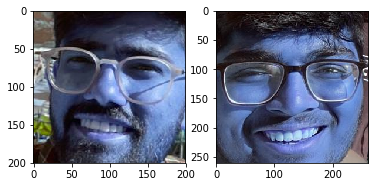

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_3.jpg


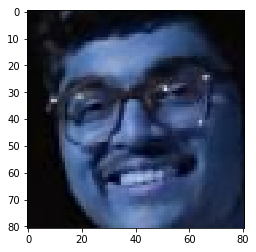

2 /kaggle/input/cv-presonal-2/cv_dataset/vidit_7.jpg


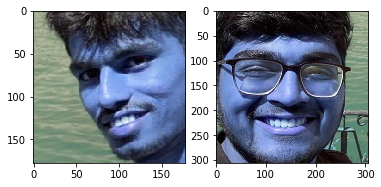

2 /kaggle/input/cv-presonal-2/cv_dataset/vidit_1.jpg


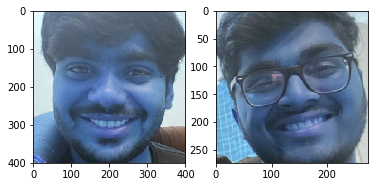

4 /kaggle/input/cv-presonal-2/cv_dataset/keshav_2.jpg


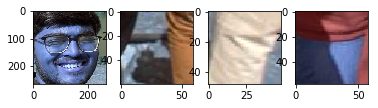

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_6.jpg


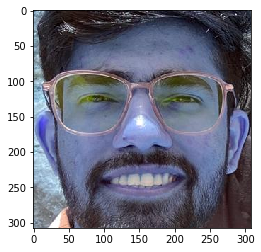

3 /kaggle/input/cv-presonal-2/cv_dataset/vidit_4.jpg


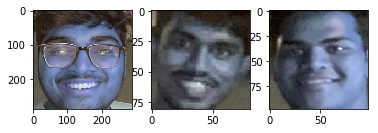

2 /kaggle/input/cv-presonal-2/cv_dataset/keshav.jpg


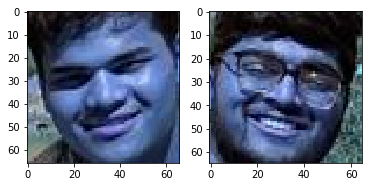

2 /kaggle/input/cv-presonal-2/cv_dataset/vidit2.jpg


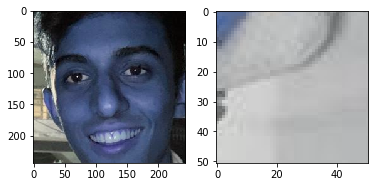

[[0.9999989  0.04563295 0.01561362 0.00371341 0.01643764 0.04247143
  0.04744506 0.04103154 0.02957687 0.00855223 0.03759418 0.04065814
  0.02256004 0.00165704 0.01110412 0.00185479 0.01925977 0.00792225
  0.0265808 ]
 [0.04563295 0.99999845 0.17016266 0.05918456 0.25383615 0.20521668
  0.4201139  0.5554104  0.1706636  0.05772931 0.24839781 0.11767329
  0.4270293  0.03948981 0.11694393 0.01312975 0.36377802 0.07289593
  0.18278395]
 [0.01561362 0.17016266 0.9999988  0.05231995 0.10137868 0.10372483
  0.21495233 0.22217028 0.09778687 0.02996471 0.14925326 0.10025454
  0.14376171 0.04382567 0.09330729 0.04975498 0.138251   0.08651409
  0.10838609]
 [0.00371341 0.05918456 0.05231995 0.99999833 0.01808284 0.08092926
  0.17936134 0.07369295 0.07923403 0.03209518 0.11497095 0.07833871
  0.09707884 0.09697442 0.17705154 0.51113987 0.03062263 0.10016595
  0.12968574]
 [0.01643764 0.25383615 0.10137868 0.01808284 0.99999857 0.05962094
  0.21023881 0.2804787  0.04780293 0.01301406 0.07180499 0.0

In [63]:
folder_path = "/kaggle/input/cv-presonal-2/cv_dataset"
# folder_path = "/kaggle/input/cv-proj-test/test_images"
image_cluster, labels_faces, all_faces = create_cluster_folder(folder_path, "/kaggle/working/")
cluster_image = {}
for image, clusters in image_cluster.items():
    for cluster in clusters:
        if cluster in cluster_image:
            cluster_image[cluster].append(image)
        else :
            cluster_image[cluster] = [image]
img_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]


In [64]:
len(labels_faces), len(all_faces)

(19, 19)

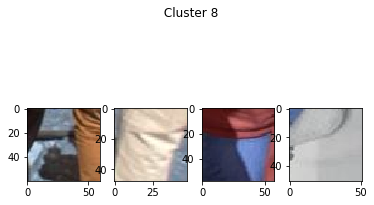

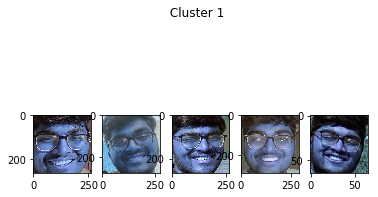

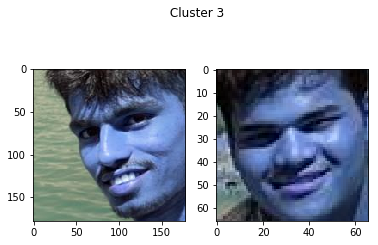

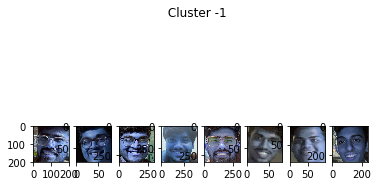

In [65]:
# Display all the clusters formed for the face images
labels_faces = np.array(list(labels_faces))
cluster_to_face = {}
for c in set(labels_faces):
#     print(c)
    ind = np.where(labels_faces == c)[0]
    cluster_to_face[c] = ind
for c in cluster_to_face:
    ind = cluster_to_face[c]
    fig, ax = plt.subplots(1, len(ind))
    for i in range(len(ind)):
        ax[i].imshow(all_faces[ind[i]])
    fig.suptitle(f" Cluster {c}")
    plt.show()
        

In [66]:
cluster_image

{-1: [0, 1, 2, 3, 5, 6, 6, 8], 1: [0, 3, 4, 6, 7], 3: [2, 7], 8: [4, 4, 4, 8]}

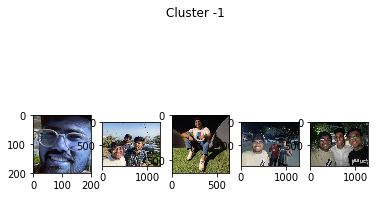

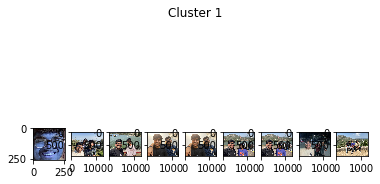

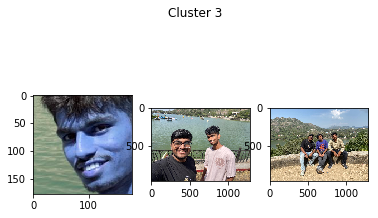

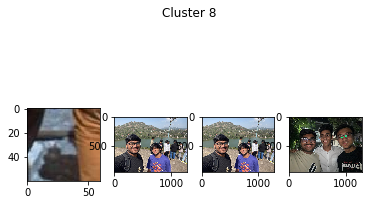

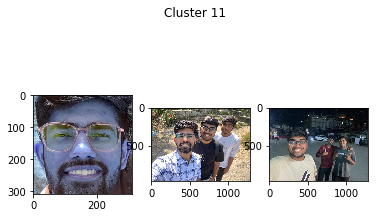

In [59]:
for i, (c, imgs) in enumerate(cluster_image.items()):
    fig, ax = plt.subplots(1, len(imgs) + 1)
    ax[0].imshow(all_faces[cluster_to_face[c][0]])
    
    for j, ind in enumerate(imgs):
        img = cv2.imread(img_paths[ind])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[j+ 1].imshow(img)
    fig.suptitle(f"Cluster {c}")
    plt.show()

In [60]:
cluster_image

{-1: [0, 1, 6, 8],
 1: [0, 2, 3, 3, 4, 4, 6, 7],
 3: [2, 7],
 8: [4, 4, 8],
 11: [5, 6]}

In [10]:

def get_clusters(similarity):
#     similarity = similarity / np.max(similarity)
    num_images = similarity.shape[0]
    clusters = {}
    image_hash = np.zeros(num_images)
    for i in range(len(image_hash)):
        if image_hash[i] == 0:
            clusters[i] = []
            image_hash[i] = 1
            for j in range(num_images):
                if (i == j or image_hash[j] == 1):
                     continue
                else :
                    if(similarity[i][j] == 1):
                        clusters[i].append(j)
                        image_hash[j] = 1
    return clusters

def image_matching(img1, img2):

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect key points and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(des1, des2, k=2)

    # ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    print(len(good_matches))   
    min_good_matches = 5 # Adjust this threshold as needed
    if len(good_matches) >= min_good_matches:
#         print("Images are similar.")
        return 1
    else:
#         print("Images are not similar.")
        return 0


In [14]:
import cv2
img1 = cv2.imread("/kaggle/input/cv-presonal-2/cv_dataset/vidit_7.jpg")
img2 = cv2.imread("/kaggle/input/cv-presonal-2/cv_dataset/vidit_5.jpg")
image_matching(img1, img2)

AttributeError: module 'cv2.cv2' has no attribute 'SIFT_create'

In [15]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
def detect_faces(img_path):
    img = cv2.imread(img_path)
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    face_images = []
    for i, (x, y, w, h) in enumerate(faces):
        # Crop the detected face region
        face_image = img[y:y+h, x:x+w, :]
        face_images.append(face_image)
#     if len(face_images) > 1:
    print(len(face_images), img_path)
    if(len(face_images) == 1):
        plt.imshow(face_images[0])
        plt.show()
    else:
        fig, ax = plt.subplots(1, len(face_images))
        for i in range(len(face_images)):
            ax[i].imshow(face_images[i])
        plt.show()
    return face_images


    
def generate_data(folder_path):
    index = 0
    data = []
    face_to_index = []
    all_faces = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        faces = detect_faces(image_path)
        all_faces += faces
        face_to_index += [index for _ in range(len(faces))]
        index += 1    
    
    n = len(all_faces)
    similarity = np.ones((n, n))
    for i in range(n):
        for j in range(i+1 , n):
            similarity[i][j] = image_matching(all_faces[i], all_faces[j])
            similarity[j][i] = similarity[i][j]    
    return similarity, face_to_index, all_faces

def cluster_embeddings(similarity):
#     similarity = cosine_similarity(data)
    clusters = get_clusters(similarity)
    cluster_labels = {}
    for i in clusters:
        if len(clusters[i]) == 0:
            cluster_labels[i] = -1
            continue
        else :
            cluster_labels[i] = i
            for x in clusters[i] :
                cluster_labels[x] = i
    return dict(sorted(cluster_labels.items())).values()

def map_images(folder_path):
    embeddings, face_to_index, all_faces = generate_data(folder_path)
    labels_faces = cluster_embeddings(embeddings)
    labels_images = {}
    for i, l in enumerate(labels_faces):
        parent_image = face_to_index[i]
        if parent_image in labels_images:
            labels_images[parent_image].append(l)
        else :
            labels_images[parent_image] = [l]
    
    return labels_images, labels_faces, all_faces

def copy_image(source_path, destination_dir):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    # Extract the filename from the source path
    filename = os.path.basename(source_path)
    
    # Construct the destination path including the filename
    destination_path = os.path.join(destination_dir, filename)
    
    # Copy the image file from source to destination
    shutil.copyfile(source_path, destination_path)


def create_cluster_folder(folder_path, cluster_folder_directory):
    image_cluster, labels_faces, all_faces = map_images(folder_path)
    # image_cluster = dict(sorted(image_cluster.items()))
    print("Image clusters Created.....")
    print("Creating cluster wise folders......")
    index = 0
#     print(image_cluster)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if index in image_cluster:
            clusters = image_cluster[index]
            for c in clusters:
                destination_path = os.path.join(cluster_folder_directory, "identity_" + str(c))
                copy_image(image_path, destination_path)
        index += 1
    return image_cluster, labels_faces, all_faces

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_5.jpg
2 /kaggle/input/cv-presonal-2/cv_dataset/vidit_5.jpg


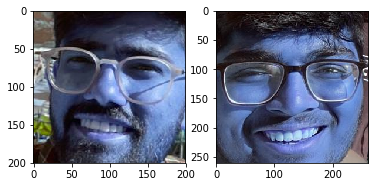

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_3.jpg


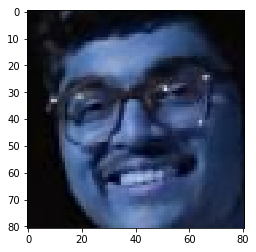

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_7.jpg
2 /kaggle/input/cv-presonal-2/cv_dataset/vidit_7.jpg


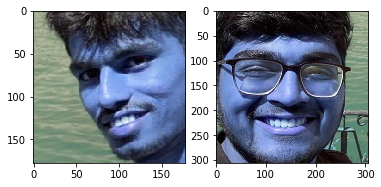

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_1.jpg
2 /kaggle/input/cv-presonal-2/cv_dataset/vidit_1.jpg


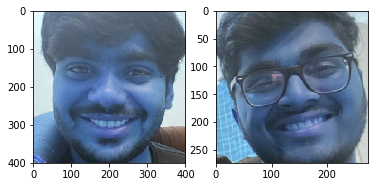

1 /kaggle/input/cv-presonal-2/cv_dataset/keshav_2.jpg
2 /kaggle/input/cv-presonal-2/cv_dataset/keshav_2.jpg
3 /kaggle/input/cv-presonal-2/cv_dataset/keshav_2.jpg
4 /kaggle/input/cv-presonal-2/cv_dataset/keshav_2.jpg


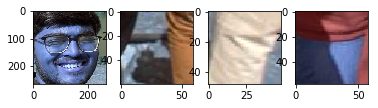

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_6.jpg


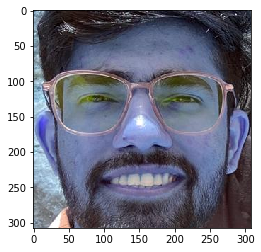

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit_4.jpg
2 /kaggle/input/cv-presonal-2/cv_dataset/vidit_4.jpg
3 /kaggle/input/cv-presonal-2/cv_dataset/vidit_4.jpg


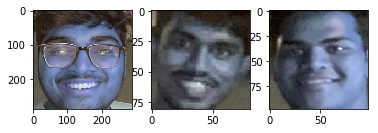

1 /kaggle/input/cv-presonal-2/cv_dataset/keshav.jpg
2 /kaggle/input/cv-presonal-2/cv_dataset/keshav.jpg


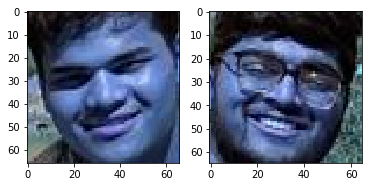

1 /kaggle/input/cv-presonal-2/cv_dataset/vidit2.jpg
2 /kaggle/input/cv-presonal-2/cv_dataset/vidit2.jpg


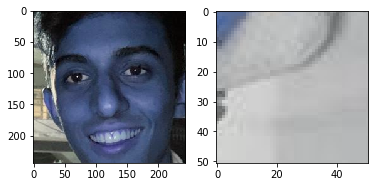

AttributeError: module 'cv2.cv2' has no attribute 'SIFT_create'

In [16]:
folder_path = "/kaggle/input/cv-presonal-2/cv_dataset"
image_cluster, labels_faces, all_faces = create_cluster_folder(folder_path, "/kaggle/working/")
cluster_image = {}
for image, clusters in image_cluster.items():
    for cluster in clusters:
        if cluster in cluster_image:
            cluster_image[cluster].append(image)
        else :
            cluster_image[cluster] = [image]
        
img_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]



In [ ]:
labels_faces = np.array(list(labels_faces))
cluster_to_face = {}
for c in set(labels_faces):
#     print(c)
    ind = np.where(labels_faces == c)[0]
    cluster_to_face[c] = ind
for c in cluster_to_face:
    ind = cluster_to_face[c]
    fig, ax = plt.subplots(1, len(ind))
    for i in range(len(ind)):
        ax[i].imshow(all_faces[ind[i]])
    fig.suptitle(f" Cluster {c}")
    plt.show()
        

In [20]:
for i, (c, imgs) in enumerate(cluster_image.items()):
    fig, ax = plt.subplots(1, len(imgs) + 1)
    ax[0].imshow(all_faces[cluster_to_face[c][0]])
    
    for j, ind in enumerate(imgs):
        img = cv2.imread(img_paths[ind])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[j+ 1].imshow(img)
    fig.suptitle(f"Cluster {c}")
    plt.show()

In [21]:
# # Convert similarity matrix to distance matrix
# from sklearn.cluster import DBSCAN

# distance_matrix = 1 - (similarity / np.max(similarity))

# # Create and fit DBSCAN model
# dbscan = DBSCAN(eps=0.8, min_samples=2, metric='precomputed')  # Adjust eps and min_samples as needed
# dbscan.fit(distance_matrix)

# # Get cluster labels
# cluster_labels = dbscan.labels_

# # Print cluster labels
# print("Cluster labels:", cluster_labels)


In [93]:

# def get_clusters(similarity):
#     similarity = similarity / np.max(similarity)
#     num_images = similarity.shape[0]
#     clusters = {}
#     image_hash = np.zeros(num_images)
#     for i in range(len(image_hash)):
#         if image_hash[i] == 0:
#             clusters[i] = []
#             image_hash[i] = 1
#             for j in range(num_images):
#                 if (i == j or image_hash[j] == 1):
#                      continue
#                 else :
#                     threshold = 0.4
#                     if(similarity[i][j] > threshold):
#                         clusters[i].append(j)
#                         image_hash[j] = 1
#     return clusters

In [97]:
# data, _ = generate_data("/kaggle/input/cv-proj-test/test_images")
# similarity = cosine_similarity(data)
# clusters = get_clusters(similarity)

2 /kaggle/input/cv-proj-test/test_images/shah_modi.jpeg


In [98]:
# clusters

{0: [8, 11, 13, 24, 25],
 1: [],
 2: [16, 17],
 3: [15, 26],
 4: [],
 5: [],
 6: [],
 7: [20],
 9: [],
 10: [],
 12: [],
 14: [],
 18: [],
 19: [28],
 21: [],
 22: [],
 23: [],
 27: []}

In [103]:
# cluster_labels = {}
# for i in clusters:
#     if len(clusters[i]) == 0:
#         cluster_labels[i] = -1
#         continue
#     else :
#         cluster_labels[i] = i
#         for x in clusters[i] :
#             cluster_labels[x] = i
# print(dict(sorted(cluster_labels.items())))

{0: 0, 1: -1, 2: 2, 3: 3, 4: -1, 5: -1, 6: -1, 7: 7, 8: 0, 9: -1, 10: -1, 11: 0, 12: -1, 13: 0, 14: -1, 15: 3, 16: 2, 17: 2, 18: -1, 19: 19, 20: 7, 21: -1, 22: -1, 23: -1, 24: 0, 25: 0, 26: 3, 27: -1, 28: 19}


In [104]:
# cluster_labels.values()

dict_values([0, 0, 0, 0, 0, 0, -1, 2, 2, 2, 3, 3, 3, -1, -1, -1, 7, 7, -1, -1, -1, -1, -1, 19, 19, -1, -1, -1, -1])

In [128]:
# folder_path = "/kaggle/input/cv-proj-test/test_images"
# img_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
# fig, ax = plt.subplots(6, 5, figsize = (10, 10))
# row = 0
# for i in (clusters):
#     for j, ind in enumerate(clusters[i]):
#         if j == 5:
#             break
#         img = cv2.imread(img_paths[ind])
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         ax[row, j].imshow(img)
#     if(len(clusters[i]) > 0):
#         row += 1

In [22]:


# # Example usage:
# n = similarity.shape[0]
# ds = DisjointSet(n)
# scores = similarity.flatten()
# decreasing_indices = get_decreasing_indices(scores)
# i = 0
# while scores[decreasing_indices[i]] > 0.5:
#     ind = decreasing_indices[i]
#     i += 1
#     x, y = ind//n, ind%n
#     ds.union(x, y)

    
# # num_clusters, cluster_info = get_cluster_info(ds)
# # print("Number of clusters:", num_clusters)
# # for label, indexes in cluster_info.items():
# #     print(f"Cluster {label}: Indexes {indexes}")


In [23]:

# get_cluster_labels(ds)